In [1]:
# Dataset: source code for 'requests' python libraray
text = open("data/requests.txt").read()

In [2]:
import numpy as np

# sorted list of all unique characters in the text
chars = sorted(list(set(text)))
vocab_size = len(chars)

# string-to-integer mapping
stoi = { char:i for i,char in enumerate(chars) }

# integer-to-string mapping
itos = { i:char for i,char in enumerate(chars) }

# lookup functions for the mappings
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# encode the entire text file and convert to a numpy array
data = np.array(encode(text))

In [3]:
import numpy as np

# Max input sequence length
max_seq_len = 1000

n_embd = 64

# Initialize embedding matrix
embedding_matrix = np.random.randn(vocab_size, n_embd)

In [4]:
def cross_entropy_loss(y_pred, y_true):

    # Add a small epsilon to the prediction to avoid log(0), which is undefined.
    epsilon = 1e-6
    
    # cross-entropy formula
    loss = -np.sum(y_true * np.log(y_pred + epsilon))

    return loss

In [5]:
class self_attention_block:
    def __init__(self, W_query, W_key, W_value):
        
        self.W_query   = W_query 
        self.W_key = W_key 
        self.W_value = W_value

        self.W_query_grad = np.zeros_like(self.W_query)
        self.W_key_grad = np.zeros_like(self.W_key)
        self.W_value_grad = np.zeros_like(self.W_value)

        self.cache = {}

        
    def forward(self, x):

        self.cache['x'] = x

        B, T, n_embd = x.shape
        
        queries = x @ self.W_query    # (B, T, n_embd)
        keys = x @ self.W_key         # (B, T, n_embd) 
        values = x @ self.W_value     # (B, T, n_embd)

        self.cache['queries'] = queries  
        self.cache['keys'] = keys
        self.cache['values'] = values

        # Make key query attention pattern
        attention_scores = (queries @ keys.transpose(0, 2, 1)) / np.sqrt(keys.shape[-1])
        self.cache['attention_scores'] = attention_scores
        
        # Create mask once
        if not hasattr(self, '_mask') or self._mask.shape != (T, T):
            self._mask = np.triu(np.ones((T, T)), k=1).astype(bool)
        
        # Apply mask more efficiently
        attention_scores_masked = attention_scores.copy()
        for b in range(B):  # Apply mask to each batch
            attention_scores_masked[b, self._mask] = -np.inf
        
        # softmax
        stable_scores = attention_scores_masked - np.max(attention_scores_masked, axis=-1, keepdims=True)
        attention_weights = np.exp(stable_scores) / np.sum(np.exp(stable_scores), axis=-1, keepdims=True)
        self.cache['attn_weights'] = attention_weights
        
        # final output: attended inputs
        output = attention_weights @ values  # (B, T, n_embd)

        return output
        
    def backward(self, d_output):
        
        # Gradient through: output = attention_weights @ values
        d_attention_weights = d_output @ self.cache['values'].transpose(0, 2, 1)
        d_values = self.cache['attn_weights'].transpose(0, 2, 1) @ d_output  

        # Apply jacobian to backprop through the softmax function
        d_attention_scores = self.cache['attn_weights'] * (d_attention_weights - np.sum(d_attention_weights * self.cache['attn_weights'], axis=-1, keepdims=True))

        # Scale factor
        scale = 1.0 / np.sqrt(self.cache['keys'].shape[-1])
        
        # Gradient through scaling
        d_attention_scores_scaled = d_attention_scores * scale
        
        # Gradient through: queries @ keys.transpose(0, 2, 1)
        d_queries = d_attention_scores_scaled @ self.cache['keys']
        d_keys = d_attention_scores_scaled.transpose(0, 2, 1) @ self.cache['queries']

        # Gradient through: queries = x @ W_query (and same for keys, values)
        self.W_query_grad, d_x_from_queries = self.linear_backward(d_queries, self.W_query, self.cache['x'])
        self.W_key_grad, d_x_from_keys = self.linear_backward(d_keys, self.W_key, self.cache['x'])  
        self.W_value_grad, d_x_from_values = self.linear_backward(d_values, self.W_value, self.cache['x'])
        
        # Sum gradients from all three paths
        d_x = d_x_from_queries + d_x_from_keys + d_x_from_values
        return d_x

    @staticmethod
    def linear_backward(d_output, W, x_from_cache):
        d_x = d_output @ W.T
        x_reshaped, dy_reshaped = x_from_cache.reshape(-1, x_from_cache.shape[-1]), d_output.reshape(-1, d_output.shape[-1])
        d_W = x_reshaped.T @ dy_reshaped
        return d_W, d_x

    def optimizer (self, learning_rate):
        self.W_query -= (self.W_query_grad * learning_rate)
        self.W_key -= (self.W_key_grad * learning_rate)
        self.W_value-= (self.W_value_grad * learning_rate)

In [6]:
class multi_head_attention:
    def __init__ (self, n_heads, n_embd):
        self.n_heads = n_heads
        self.head_dim = n_embd // n_heads

        # Create multiple attention heads
        self.heads = []
        for i in range(n_heads):
            # Each head gets its own Q, K, V projections
            W_q = np.random.randn(n_embd, self.head_dim) * 0.02
            W_k = np.random.randn(n_embd, self.head_dim) * 0.02
            W_v = np.random.randn(n_embd, self.head_dim) * 0.02
            self.heads.append(self_attention_block(W_q, W_k, W_v))
        
        # Output projection to combine all heads
        self.W_output = np.random.randn(n_embd, n_embd) * 0.02

        self.W_output_grad = np.zeros_like(self.W_output)

        self.cache = {}

    @staticmethod
    def linear_backward(d_output, W, x_from_cache):

        # d_W = x.T @ dy
        # d_x = dy @ W.T

        d_x = d_output @ W.T

        # Flaten weight and input arrays to calculate weight gradients
        x_reshaped, dy_reshaped = x_from_cache.reshape(-1, x_from_cache.shape[-1]), d_output.reshape(-1, d_output.shape[-1])
        d_W = x_reshaped.T @ dy_reshaped

        return d_W, d_x

    def forward(self, x):
        # Run each head
        head_outputs = []
        for head in self.heads:
            head_outputs.append(head.forward(x))
        
        # Concatenate along embedding dimension
        concat_output = np.concatenate(head_outputs, axis=-1)  # (B, T, n_embd)
        self.cache['concat_output'] = concat_output
        
        # Final projection
        output = concat_output @ self.W_output
        return output

    def backward(self, d_output):

        self.W_output_grad, d_concat = self.linear_backward(d_output, self.W_output, self.cache['concat_output'])

        head_gradients = np.split(d_concat, self.n_heads, axis=-1)

        # Return sum of head's gradients
        d_x_sum = None
        for i, head_grad in enumerate(head_gradients):
            d_x = self.heads[i].backward(head_grad)
            if d_x_sum is None:
                d_x_sum = d_x
            else:
                d_x_sum += d_x 
        
        return d_x_sum

    def optimizer(self, learning_rate):
        self.W_output -= (self.W_output_grad * learning_rate)
        for head in self.heads:
            head.optimizer(learning_rate)

        

In [7]:
class LayerNorm:
    def __init__ (self, n_embd):

        self.n_embd = n_embd
        self.gamma = np.ones((n_embd,))
        self.beta = np.zeros((n_embd,))

        self.gamma_grad = np.zeros_like(self.gamma)
        self.beta_grad = np.zeros_like(self.beta)

        self.cache = {}
        
    def forward (self, x):

        # x: (B, T, n_embd)
        mean = x.mean(axis=-1, keepdims=True)
        variance = x.var(axis=-1, keepdims=True)
        epsilon = 1e-5 # A standard small value for epsilon

        # Input vector scaled to have a mean of 0 and variance of 1
        x_normalized = (x - mean) / np.sqrt(variance + epsilon)
        
        # Cache values needed for the backward pass
        self.cache['x_normalized'] = x_normalized
        self.cache['gamma'] = self.gamma
        self.cache['std_dev'] = np.sqrt(variance + epsilon)

        return x_normalized * self.gamma + self.beta

    
    def backward (self, d_output):

        # Calculate gradients for gamma and beta
        # These are summed over the batch and time dimensions to match the parameter shapes
        self.beta_grad = np.sum(d_output, axis=(0,1))
        self.gamma_grad = np.sum(d_output * self.cache['x_normalized'], axis=(0,1))

        # Calculate the gradient for the input x (the error signal to pass back)
        N = self.n_embd
        std_dev = self.cache['std_dev']
        x_norm = self.cache['x_normalized']
        gamma = self.cache['gamma']

        # Backprop through the scale and shift (y = gamma * x_norm + beta)
        d_x_norm = d_output * gamma
        
        # Backprop through the normalization
        sum1 = np.sum(d_x_norm, axis=-1, keepdims=True)
        sum2 = np.sum(d_x_norm * x_norm, axis=-1, keepdims=True)
        
        d_x = (1 / (N * std_dev)) * (N * d_x_norm - sum1 - x_norm * sum2)
        
        return d_x
        
    def optimizer (self, learning_rate):
        
        self.gamma -= (self.gamma_grad * learning_rate)
        self.beta -= (self.beta_grad * learning_rate)

In [8]:
class Transformer:
    def __init__ (self, W1, W2, n_attn_heads, n_embd):
        self.W1 = W1
        self.W2 = W2
        self.multi_head_attention_block = multi_head_attention(n_attn_heads, n_embd)

        self.W1_grad = np.zeros_like(self.W1)
        self.W2_grad = np.zeros_like(self.W2)

        self.layer_norm1 = LayerNorm(n_embd)
        self.layer_norm2 = LayerNorm(n_embd)

        self.cache = {}

    def forward (self, x): 

        attn_output = self.multi_head_attention_block.forward(x)
        self.cache['attn_output'] = attn_output

        add_output_1 = x + attn_output  # Residual connection step
        norm_output_1 = self.layer_norm1.forward(add_output_1)  # Layer norm step
        self.cache['norm_output_1'] = norm_output_1
                
        hidden = norm_output_1 @ self.W1
        self.cache['hidden'] = hidden
        
        hidden_activated = np.maximum(0, hidden)
        self.cache['hidden_activated'] = hidden_activated 
        
        processed_vectors = hidden_activated @ self.W2 # Shape: (B, T, n_embd)
        self.cache['processed_vectors'] = processed_vectors

        add_output_2 = norm_output_1 + processed_vectors   # Residual connection step
        norm_output_2 = self.layer_norm2.forward(add_output_2) # Layer norm step
        self.cache['norm_output_2'] = norm_output_2

        return norm_output_2

    def backward (self, d_output):

        # Error gradient from last residiual connection step, calculated on LayerNorm.backwards()
        d_add2 = self.layer_norm2.backward(d_output)

        # Fork error signal
        d_processed_vectors = d_add2
        d_norm_output_1_from_residual = d_add2

        # Put d_processed_vectors through FFN backprop
        # Activated hidden layer
        grad_W2, d_hidden_activated = self.linear_backward(d_processed_vectors, self.W2, self.cache['hidden_activated'])
        self.W2_grad = grad_W2

        # Relu backprop
        d_hidden = d_hidden_activated * (self.cache['hidden'] > 0)

        # Hidden layer
        grad_W1, d_norm_output_1_from_ffn = self.linear_backward(d_hidden, self.W1, self.cache['norm_output_1'])
        self.W1_grad = grad_W1

        # Recombine error gradients 
        d_norm_output_1_total = d_norm_output_1_from_ffn + d_norm_output_1_from_residual

        # Error gradient from first residiual connection step, calculated on LayerNorm.backwards()
        d_add1 = self.layer_norm1.backward(d_norm_output_1_total)

        d_attn_output = d_add1
        d_x_from_residual = d_add1

        # Attention block    
        d_x_from_attention = self.multi_head_attention_block.backward(d_attn_output)

        d_attn_input = d_x_from_residual + d_x_from_attention

        return d_attn_input

    def optimizer(self, learning_rate): 

        self.multi_head_attention_block.optimizer(learning_rate)

        self.layer_norm1.optimizer(learning_rate)
        self.layer_norm2.optimizer(learning_rate)
        
        self.W1 -= (self.W1_grad * learning_rate)
        self.W2 -= (self.W2_grad * learning_rate)
        
    @staticmethod
    def linear_backward(d_output, W, x_from_cache):

        # d_W = x.T @ dy
        # d_x = dy @ W.T

        d_x = d_output @ W.T

        # Flaten weight and input arrays to calculate weight gradients
        x_reshaped, dy_reshaped = x_from_cache.reshape(-1, x_from_cache.shape[-1]), d_output.reshape(-1, d_output.shape[-1])
        d_W = x_reshaped.T @ dy_reshaped

        return d_W, d_x
        

In [9]:
class Model:
    def __init__(self,embedding_matrix, temperature=1.0, max_sequence_length=1000, n_embd=64, n_transformers=6, ffwd_expansion_factor=4):

        # Initialize weight matrices
        self.embedding_matrix = embedding_matrix
        self.position_matrix = np.random.randn(max_sequence_length, n_embd)

        # Hidden layer initialization functions
        
        # Transformers 
        self.transformers = []
        
        for i in range(n_transformers):
            
            # Hidden layer initialization 
            W1 = np.random.randn(n_embd, n_embd * ffwd_expansion_factor) * np.sqrt(2.0 / n_embd)
            W2 = np.random.randn(n_embd * ffwd_expansion_factor, n_embd) * np.sqrt(2.0 / (n_embd * ffwd_expansion_factor))

            # Append transformer
            self.transformers.append(Transformer(W1, W2, n_attn_heads=8, n_embd=n_embd))

        self.cache = {} # A dictionary to store forward pass values

        self.n_transformers = n_transformers

        # Temperature hyperparameter
        self.temperature = temperature
        
        # Gradient buckets
        self.embedding_matrix_grad = np.zeros_like(self.embedding_matrix)
        self.position_matrix_grad = np.zeros_like(self.position_matrix)


    def forward(self, x_batch):
        
        x_batch = np.array(x_batch)
        if x_batch.ndim == 1:
            x_batch = x_batch[None, :]  # Add batch dimension: (T,) -> (1, T)
        
        self.cache['x_batch'] = x_batch

        # Output shape: (B, T, n_embd)
        embd = self.embedding_matrix[x_batch]
        self.cache['embd'] = embd

        # Positional embeddings
        B, T = x_batch.shape
        pos = self.position_matrix[:T]  # Slice for sequence length
        self.cache['pos'] = pos
        
        # Add position to token embeddings
        attn_input = embd + pos
        self.cache['attn_input'] = attn_input
        
        # Put data through transformers
        transformer_output = attn_input
        
        for transformer in self.transformers:
            transformer_output = transformer.forward(transformer_output)
            
        self.cache['transformer_output'] = transformer_output
        
        logits = transformer_output @ self.embedding_matrix.T

        return logits

    def pred (self, x):

        logits = self.forward(x)[0, -1]  # Get batch 0, last position
        
        scaled_logits = logits / self.temperature
        
        ## Apply softmax function to logits
        stable_logits = scaled_logits - np.max(scaled_logits) # This ensures the largest logit is 0
        preds = np.exp(stable_logits) / np.sum(np.exp(stable_logits))       
        
        char_pred = np.random.choice(range(0, len(chars)), p=preds)
        
        return char_pred

    def calc_loss (self, logits, y_batch):

        # Get the dimensions for indexing
        B, T, C = logits.shape

        # Stable softmax
        max_logits = np.max(logits, axis=-1, keepdims=True)
        stable_logits = logits - max_logits
        exp_logits = np.exp(stable_logits)
        probabilities = exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)
    
        # Get the probabilities for the correct target characters using efficient indexing
        correct_char_probs = probabilities[np.arange(B)[:, None], np.arange(T), y_batch]

        # Calculate negative log likelihood
        loss_array = -np.log(correct_char_probs + 1e-9)
    
        # Average the loss over the whole batch to get a single number
        mean_loss = np.mean(loss_array)

        self.loss = mean_loss
        
        # Return probabilities because they are the starting point for backpropagation
        return mean_loss, probabilities

    
    # Calculates the gradients for a specific layer and it's resulting vector
    @staticmethod
    def linear_backward(d_output, W, x_from_cache):

        # d_W = x.T @ dy
        # d_x = dy @ W.T

        d_x = d_output @ W.T

        # Flaten weight and input arrays to calculate weight gradients
        x_reshaped, dy_reshaped = x_from_cache.reshape(-1, x_from_cache.shape[-1]), d_output.reshape(-1, d_output.shape[-1])
        d_W = x_reshaped.T @ dy_reshaped

        return d_W, d_x


    def backward (self, d_logits):

        # Reset gradients at start of backward pass
        self.embedding_matrix_grad.fill(0)
        self.position_matrix_grad.fill(0)
        
        # Unembedding layer - handle tied weights correctly
        d_transformer_output = d_logits @ self.embedding_matrix  # gradient w.r.t transformer output

        transformer_output = self.cache['transformer_output']
        
        # Gradient w.r.t embedding matrix from unembedding (transposed)
        B, T, n_embd = transformer_output.shape
        transformer_output_flat = transformer_output.reshape(-1, n_embd)  # Shape: (B*T, n_embd)
        d_logits_flat = d_logits.reshape(-1, d_logits.shape[-1])  # Shape: (B*T, vocab_size)
        
        unembedding_grad = transformer_output_flat.T @ d_logits_flat
        
        # Add unembedding gradient to embedding matrix gradients
        self.embedding_matrix_grad += unembedding_grad.T
        
        # Loop in reverse order through transformers
        current_grad = d_transformer_output
        
        for transformer in reversed(self.transformers):
            current_grad = transformer.backward(current_grad)

        d_attn_input = current_grad


         # Split gradient between embeddings and positions (attn_input = embd + pos)
        d_embed = d_attn_input  
        d_pos = d_attn_input  
        
        # Update position matrix gradients
        B, T = self.cache['x_batch'].shape
        self.position_matrix_grad[:T] += np.sum(d_pos, axis=0)  # Sum over batch dimension
    
        # Perform reverse lookup on embedding array
        np.add.at(self.embedding_matrix_grad, self.cache['x_batch'], d_embed)

    def optimizer (self, learning_rate): 

        self.embedding_matrix -= (self.embedding_matrix_grad * learning_rate)
        self.position_matrix -= (self.position_matrix_grad * learning_rate)
        
        for transformer in self.transformers:
            transformer.optimizer(learning_rate)


In [10]:
model = Model(embedding_matrix)
# Get next character predictions for 'd'
logits = model.forward([[stoi['a'], stoi['p']]])
model.pred([int(stoi['r'])])

/var/folders/8k/dg_kyxnn5wn4nbhpwfq40c2r0000gn/T/ipykernel_54222/1034086775.py:47: RuntimeWarning: divide by zero encountered in matmul
  output = concat_output @ self.W_output
/var/folders/8k/dg_kyxnn5wn4nbhpwfq40c2r0000gn/T/ipykernel_54222/1034086775.py:47: RuntimeWarning: overflow encountered in matmul
  output = concat_output @ self.W_output
/var/folders/8k/dg_kyxnn5wn4nbhpwfq40c2r0000gn/T/ipykernel_54222/1034086775.py:47: RuntimeWarning: invalid value encountered in matmul
  output = concat_output @ self.W_output
/var/folders/8k/dg_kyxnn5wn4nbhpwfq40c2r0000gn/T/ipykernel_54222/3072446633.py:24: RuntimeWarning: divide by zero encountered in matmul
  hidden = norm_output_1 @ self.W1
/var/folders/8k/dg_kyxnn5wn4nbhpwfq40c2r0000gn/T/ipykernel_54222/3072446633.py:24: RuntimeWarning: overflow encountered in matmul
  hidden = norm_output_1 @ self.W1
/var/folders/8k/dg_kyxnn5wn4nbhpwfq40c2r0000gn/T/ipykernel_54222/3072446633.py:24: RuntimeWarning: invalid value encountered in matmul
  hid

np.int64(92)

In [11]:
import random

def get_batch(data, batch_size, block_size):

    x_batch = []
    y_batch = []

    # Generate batchs 
    for block in [0] * batch_size:

        # Get random range in datast of size=block_size
        slice_idx = random.randrange(0, len(data) - block_size)
        x_batch.append(data[slice_idx:slice_idx+block_size])
        y_batch.append(data[slice_idx+1:slice_idx+block_size+1])

    return np.array(x_batch), np.array(y_batch)



In [12]:
def clip_gradients(model, max_norm=1.0):
    total_norm = 0
    
    # Calculate total gradient norm
    total_norm += np.sum(model.embedding_matrix_grad ** 2)
    total_norm += np.sum(model.position_matrix_grad ** 2)
    
    for transformer in model.transformers:
        total_norm += np.sum(transformer.W1_grad ** 2)
        total_norm += np.sum(transformer.W2_grad ** 2)
        total_norm += np.sum(transformer.layer_norm1.gamma_grad ** 2)
        total_norm += np.sum(transformer.layer_norm1.beta_grad ** 2)
        total_norm += np.sum(transformer.layer_norm2.gamma_grad ** 2)
        total_norm += np.sum(transformer.layer_norm2.beta_grad ** 2)
        
        total_norm += np.sum(transformer.multi_head_attention_block.W_output_grad ** 2)
        for head in transformer.multi_head_attention_block.heads:
            total_norm += np.sum(head.W_query_grad ** 2)
            total_norm += np.sum(head.W_key_grad ** 2)
            total_norm += np.sum(head.W_value_grad ** 2)
    
    total_norm = np.sqrt(total_norm)
    
    # Scale gradients if norm exceeds threshold
    if total_norm > max_norm:
        scale = max_norm / total_norm
        
        model.embedding_matrix_grad *= scale
        model.position_matrix_grad *= scale
        
        for transformer in model.transformers:
            transformer.W1_grad *= scale
            transformer.W2_grad *= scale
            transformer.layer_norm1.gamma_grad *= scale
            transformer.layer_norm1.beta_grad *= scale
            transformer.layer_norm2.gamma_grad *= scale
            transformer.layer_norm2.beta_grad *= scale
            transformer.multi_head_attention_block.W_output_grad *= scale
            
            for head in transformer.multi_head_attention_block.heads:
                head.W_query_grad *= scale
                head.W_key_grad *= scale
                head.W_value_grad *= scale

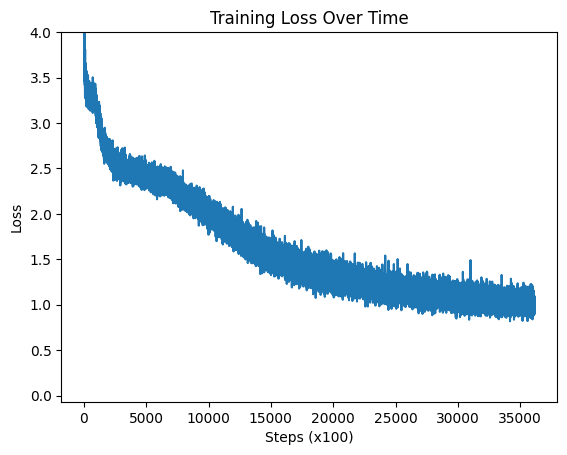

In [ ]:
import matplotlib.pyplot as plt
from IPython import display
%matplotlib notebook

# Training hyperparameters
max_iters = 100000
learning_rate = 3e-5
batch_size = 32
block_size = 128

np.seterr(all='ignore')

# --- Plotting Initialization ---
plot_losses = []
fig, ax = plt.subplots()

print("Training model")

# Training loop
for step in range(max_iters):
    
    # Get a mini-batch of data
    # Note: Corrected the order of batch_size and block_size from user's original training loop code
    x_batch, y_batch = get_batch(data, batch_size, block_size)
    
    # Calculate loss and probabilites
    logits = model.forward(x_batch)
    loss_initial, probabilities = model.calc_loss(logits, y_batch)

    plot_losses.append(loss_initial)

    # Backward Pass
    one_hot_array = np.eye(vocab_size)[y_batch]
    initial_gradient = probabilities - one_hot_array
    
    model.backward(initial_gradient)

    # Optimizer
    model.optimizer(learning_rate)

    if step % 10 == 0:
        print(f"Step {step}, Loss: {loss_initial}")
        
        # --- Live Plotting Logic ---
        display.clear_output(wait=True)
        ax.clear()
        ax.plot(plot_losses)
        ax.set_title("Training Loss Over Time")
        ax.set_xlabel("Steps (x10)")
        ax.set_ylabel("Loss")
        if loss_initial < 4:
            ax.set_ylim(top=4) # cut off loses higher than 4
        display.display(fig)
        # ---

# Final clear to show the last plot cleanly
display.clear_output(wait=True)
ax.clear()
ax.plot(plot_losses)
ax.set_title("Final Training Loss")
ax.set_xlabel("Steps (x100)")
ax.set_ylabel("Loss")

print(f"Model loss: {model.loss}")

In [ ]:
# Control the model's 'creativity'
temperature = .9
model.temperature = temperature

# Let the model generate some code!
initial_char = "\n"

generation_length = 10
charIdxs = [int(stoi[initial_char])]

for i in range(generation_length):
    charIdxs.append(model.pred(charIdxs))

char_preds = [itos[charIdx] for charIdx in charIdxs]
print("".join(char_preds))

In [ ]:
### Compile all model weights into organized python dict
weights_dict = {
    "embedding_matrix": model.embedding_matrix,
    "position_matrix": model.position_matrix,
}

for idx, transformer in enumerate(model.transformers):
    weights_dict[f"transform.{idx}.W1"] = transformer.W1
    weights_dict[f"transform.{idx}.W2"] = transformer.W2
    weights_dict[f"transform.{idx}.layer_norm1.gamma"] = transformer.layer_norm1.gamma
    weights_dict[f"transform.{idx}.layer_norm1.beta"] = transformer.layer_norm1.beta
    weights_dict[f"transform.{idx}.layer_norm2.gamma"] = transformer.layer_norm2.gamma
    weights_dict[f"transform.{idx}.layer_norm2.beta"] = transformer.layer_norm2.beta
    weights_dict[f"transform.{idx}.multi_head_attention_block.W_output"] = transformer.multi_head_attention_block.W_output
    
    for index, attention_head in enumerate(transformer.multi_head_attention_block.heads):
        weights_dict[f"transform.{idx}.multi_head_attention_block.heads.{index}.key"] = attention_head.W_key
        weights_dict[f"transform.{idx}.multi_head_attention_block.heads.{index}.query"] = attention_head.W_query
        weights_dict[f"transform.{idx}.multi_head_attention_block.heads.{index}.value"] = attention_head.W_value

# Save to compressed model file 
np.savez_compressed('my_model.npz', **weights_dict)